<a href="https://colab.research.google.com/github/cesar-claros/synergistic/blob/SocialAds/Fashion_MNIST_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch
!pip install gpytorch
!pip install tensorflow-determinism

     |████████████████████████████████| 503 kB 13.3 MB/s 
  Created wheel for tensorflow-determinism: filename=tensorflow_determinism-0.3.0-py3-none-any.whl size=9157 sha256=1f8be49d1c45ae7f8cb17ab80ebe104beb6f02231cc43f60446d29d5982bc396
  Stored in directory: /root/.cache/pip/wheels/d2/be/33/2b27e81e5d40b4bfb7c103ac6c6c5e81fdbcf40d2af5078529
Successfully built tensorflow-determinism


In [2]:
!git clone https://github.com/cesar-claros/synergistic
%cd synergistic/

Cloning into 'synergistic'...
remote: Enumerating objects: 249, done.
remote: Counting objects: 100% (249/249), done.
remote: Compressing objects: 100% (233/233), done.
remote: Total 249 (delta 108), reused 43 (delta 13), pack-reused 0
Receiving objects: 100% (249/249), 19.07 MiB | 10.02 MiB/s, done.
Resolving deltas: 100% (108/108), done.
/content/synergistic


In [3]:
# %%
# Imports
import io #Used as buffer
import sys
import matplotlib
import tensorflow as tf # Keras model for MNIST 
# matplotlib.use('qt5Agg')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import auxfunc.funcs as sgn
import seaborn as sns
import torch
from scipy.stats import entropy, spearmanr
from sklearn import model_selection, svm, ensemble, linear_model, pipeline, metrics,\
      tree, neighbors, discriminant_analysis, gaussian_process, preprocessing, impute, decomposition
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, Matern
plt.style.use(['ggplot','style/style.mplstyle'])
import os
import random

In [4]:
#%%
# Define classic MLP architecture
def CNN_model(input_dim):
    # A simple model based off LeNet from https://keras.io/examples/mnist_cnn/
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=input_dim ))
    model.add(tf.keras.layers.Conv2D(64, [3, 3], activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    return model

In [5]:
#%%
# Initialize model
def init_model(input_dim):
    # svm = False
    # model = MLP_model(input_dim=Data_X.shape[1], svm_obj=svm)
    model = CNN_model(input_dim=input_dim)
    loss = tf.keras.losses.categorical_crossentropy
    metric = ['accuracy']
    model.compile(loss=loss,
                optimizer=tf.keras.optimizers.Adam(),
                metrics=metric)
    # model.summary()
    return model

In [6]:
#%%
# Signaling function fitting and evaluation
def signalingFunction(X_train, y_train, y_train_pred_th, X_val, y_val, y_val_pred_th, X_test, y_test, y_test_pred_th, kernel='exponential', norm='l01', ex_dim=1):
    # X_train, X_val should be scaled
    # Fit signaling function 
    exp = sgn.signaling(norm=norm) # idx = [train,test,val]
    exp.fit(X_train, y_train, y_train_pred_th, kernel=kernel, n_iter=500, lr=0.01, ex_dim=ex_dim)
    table_val = exp.evaluate(X_val, y_val, y_val_pred_th, rule_grid=np.linspace(0,3,30, endpoint=False), rho_grid=[0.1, 0.15])
    table_test = exp.test(X_test, y_test, y_test_pred_th, table_val['rule'].to_numpy(), table_val['eta'].to_numpy())
    table = pd.concat([table_val,table_test],axis=1)
    return table, exp

In [7]:
#%%
# Soft and thresholded output predictions
def pred_output(model, X):
    y_pred_soft = model.predict(X)
    y_pred_th = np.argmax(y_pred_soft, axis=1)
    return y_pred_soft, y_pred_th

In [8]:
#%%
# Jaccard similarity index
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    return len(s1.intersection(s2)) / len(s1.union(s2))

In [9]:
#%%
# Baseline comparison
def baselineCriteria(y_val, y_val_pred_soft, y_val_pred_th, y_test, y_test_pred_soft, y_test_pred_th, table, exp):
      direction = 'further'
      # p_val = np.concatenate(y_val_pred_soft,axis=1)
      crit_val = entropy(y_val_pred_soft, axis=1, base=10)
      # p_test = np.concatenate(y_test_pred_soft,axis=1)
      crit_test = entropy(y_test_pred_soft, axis=1, base=10)
      
      critFunc = sgn.critEvaluation(norm='l01',direction=direction)
      d_val = critFunc.evaluate(y_val, y_val_pred_th, crit_val, rho_grid=[0.1, 0.15])
      d_test = critFunc.test(y_test, y_test_pred_th, crit_test, d_val['thresh'].to_numpy())
      crit_table = pd.concat([d_val,d_test],axis=1)

      gamma = table['rule'].to_numpy().reshape(-1,1)
      f_test = exp.gpr_mean_test + gamma*np.sqrt(exp.gpr_var_test)
      eta = table['eta'].to_numpy().reshape(-1,1)
      theta = crit_table['thresh'].to_numpy().reshape(-1,1)
      if direction == 'closer':
        f_mask, f_idx = np.nonzero(f_test>eta)
      else:
        f_mask, f_idx = np.nonzero(f_test<eta)
      crit_mask, crit_idx = np.nonzero(crit_test.reshape(1,-1)<theta)
      print(list(np.unique(f_mask)))
      print(list(np.unique(crit_mask)))
      print(f_test.shape[0])
      shared = set(list(np.unique(f_mask))).intersection(set(list(np.unique(crit_mask))))
      J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) if i in shared else np.nan for i in range(f_test.shape[0])]
      # if (list(np.unique(f_mask))==list(np.unique(crit_mask))):
      #   J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) for i in np.unique(f_mask)]
      # else:
      #   shared = set(a).intersection(set(b))
      #   union = set(a).union(set(b))
      #   J = [jaccard_similarity(crit_idx[crit_mask==i],f_idx[f_mask==i]) if i in shared else np.nan  for i in union]
      crit_table['jaccard']=J
      Sp = [spearmanr(f_test[i,:],crit_test)[0] for i in range(f_test.shape[0])]
      crit_table['spearman'] = Sp
      crit_table['gamma'] = gamma
      return crit_table

In [10]:
# For reproducibility
os.environ['TF_DETERMINISTIC_OPS'] = '1'
SEED = 123456
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [11]:
# %%
# INITIALIZATION
# ==============
# EXPERIMENT SETUP
# ================
# Load data set
(Data_X, Data_y), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
# y, y_test = y.astype('int8'), y_test.astype('int8')
# Rescale the images from [0,255] to the [0.0,1.0] range.
Data_X, X_test = Data_X[..., np.newaxis]/255.0, X_test[..., np.newaxis]/255.0
print("Number of original training examples:", len(Data_X))
# reshape the data
# Data_X = Data_X.reshape(60000, 28*28).astype('float32')
# X_test = X_test.reshape(10000, 28*28).astype('float32')
# for keras classification, we need to use `to_categorical` to transform the label to appropriate format
# Data_y = tf.keras.utils.to_categorical(Data_y)
# y_test = tf.keras.utils.to_categorical(y_test)
Data_X, Data_X_sep, Data_y, Data_y_sep = model_selection.train_test_split(Data_X, Data_y, stratify=Data_y, test_size=0.75, random_state=SEED)
X_test, X_test_sep, y_test, y_test_sep = model_selection.train_test_split(X_test, y_test, stratify=y_test, test_size=0.75, random_state=SEED)

4431872/4422102 [==============================] - 0s 0us/step
Number of original training examples: 60000


In [ ]:
#%%
# Assign labels
report_table = []
report_criteria = []
report_plot = []
kf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
clf = 'softmax_act'
addPredictions = True
accuracy = 0
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1)
y_test = tf.keras.utils.to_categorical(y_test)
for train, val in kf.split(Data_X, Data_y):
    # print(train[:10])
    # print(val[:10])
    
    X_train = Data_X[train]
    y_train = Data_y[train]
    # print(y_train[:10])
    y_train = tf.keras.utils.to_categorical(y_train)
    X_val = Data_X[val]
    y_val = Data_y[val]
    # print(y_val[:10])
    y_val = tf.keras.utils.to_categorical(y_val)
    
    # sample = sample[:12500]
    # test = test[:2000]
    # X = Data_X[sample]
    # y = Data_y[sample]
    # X_train, X_val, y_train, y_val = model_selection.train_test_split(X, y, test_size=0.20, random_state=123)
    # X_test = Data_X[test]
    # y_test = Data_y[test]

    # TRAINING MODEL
    model = init_model(input_dim=Data_X.shape[1:])
    model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=0, validation_data=(X_val, y_val), callbacks=[es])
    # model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=0, validation_data=(X_val, y_val))

    y_train_pred_soft, y_train_pred_th = pred_output(model, X_train)
    print('accuracy(Train)={}'.format(np.sum(y_train_pred_th==np.argmax(y_train,axis=1))/y_train_pred_th.size))
    y_val_pred_soft, y_val_pred_th = pred_output(model, X_val)
    y_test_pred_soft, y_test_pred_th = pred_output(model, X_test)

    if clf == 'softmax_act':
            activation_model = tf.keras.models.Model(inputs=model.input, outputs=model.layers[5].output)
            X_train_GP = activation_model.predict(X_train)
            X_val_GP = activation_model.predict(X_val)
            X_test_GP = activation_model.predict(X_test)
    elif clf == 'softmax':
            X_train_GP = X_train.reshape(-1,np.prod(X_train.shape[1:]))
            X_val_GP = X_val.reshape(-1,np.prod(X_val.shape[1:]))
            X_test_GP = X_test.reshape(-1,np.prod(X_test.shape[1:]))

    # X_train_GP = X_train.reshape(-1,np.prod(X_train.shape[1:]))
    # X_val_GP = X_val.reshape(-1,np.prod(X_val.shape[1:]))
    # X_test_GP = X_test.reshape(-1,np.prod(X_test.shape[1:]))
    if addPredictions:
            # Add predictions
            # y_train_pred_soft = y_train_pred_soft[:,1:]
            # y_val_pred_soft = y_val_pred_soft[:,1:]
            # y_test_pred_soft = y_test_pred_soft[:,1:]
            X_train_GP = np.concatenate((X_train_GP, y_train_pred_soft), axis=1)
            X_val_GP = np.concatenate((X_val_GP, y_val_pred_soft), axis=1)
            X_test_GP = np.concatenate((X_test_GP, y_test_pred_soft), axis=1)
    scaleX_GP = preprocessing.StandardScaler().fit(np.concatenate((X_train_GP, X_val_GP), axis=0))
    X_train_GP = scaleX_GP.transform(X_train_GP)
    X_val_GP = scaleX_GP.transform(X_val_GP)
    X_test_GP = scaleX_GP.transform(X_test_GP)

    table, exp = signalingFunction(X_train_GP, np.argmax(y_train, axis=1), y_train_pred_th, \
                                   X_val_GP, np.argmax(y_val, axis=1), y_val_pred_th,\
                                   X_test_GP, np.argmax(y_test, axis=1), y_test_pred_th,\
                                   kernel='e*e', ex_dim=y_train_pred_soft.shape[1])
    print('gpr_mean=',exp.gpr_mean_test[:10])
    print('gpr_mean=',exp.gpr_mean_val[:10])

    report_table.append(table)
    # Baseline for comparison
    crit_table = baselineCriteria(np.argmax(y_val, axis=1), y_val_pred_soft, y_val_pred_th,\
                                  np.argmax(y_test, axis=1), y_test_pred_soft, y_test_pred_th,\
                                  table, exp)
    report_criteria.append(crit_table)

    score = np.sum(np.argmax(y_val, axis=1)==y_val_pred_th)/np.size(np.argmax(y_val, axis=1))
    if accuracy < score:
      accuracy = score
      table_best = table
      crit_table_best = crit_table
      exp_best = exp
      y_test_best = y_test
      y_test_pred_soft_best = y_test_pred_soft
      y_test_pred_th_best = y_test_pred_th
      X_test_best = X_test
    del(model)

Epoch 00009: early stopping
accuracy(Train)=0.9275
initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: -0.158  noise: 0.027
Iter 492/500 - Loss: -0.157  noise: 0.027
Iter 493/500 - Loss: -0.158  noise: 0.027
Iter 494/500 - Loss: -0.159  noise: 0.027
Iter 495/500 - Loss: -0.159  noise: 0.027
Iter 496/500 - Loss: -0.160  noise: 0.027
Iter 497/500 - Loss: -0.160  noise: 0.027
Iter 498/500 - Loss: -0.160  noise: 0.027
Iter 499/500 - Loss: -0.160  noise: 0.026
Iter 500/500 - Loss: -0.162  noise: 0.026
evaluating with cuda...
evaluating with cuda...
gpr_mean= [-0.01064299  0.0782818   0.0526741   0.04481882  0.00377575 -0.00301257
  0.00344874  0.00371097 -0.00224955 -0.00094713]
gpr_mean= [-0.0081403   0.00707719  0.20094126 -0.00488847  0.00078772 -0.00171351
  0.00468378  0.00355525  0.00053428  0.05881806]
[0, 1]
[0, 1]
2
Epoch 00008: early stopping
accuracy(Train)=0.9224166666666667
initializing cuda...
lr=0.01, n_iterations=500
Iter 491/500 - Loss: -0.120  noise: 0.029


In [ ]:
logs_base_dir = "runs/"
%tensorboard --logdir {logs_base_dir}

In [ ]:
rho = 0.15
X_test_best = X_test_best.squeeze()
rule = table_best.loc[table_best.rho_user == rho]['rule'].to_numpy()
eta = table_best.loc[table_best.rho_user == rho]['eta'].to_numpy()[0]
theta = crit_table_best.loc[crit_table_best.rho_user == rho]['thresh'].to_numpy()[0]
f_test = exp_best.gpr_mean_test+rule*np.sqrt(exp_best.gpr_var_test)
top_n = 5 # Top n selected instances in test set
top_f_idx = np.argpartition(f_test, -top_n)[-top_n:]
top_f_idx = top_f_idx[np.argsort(f_test[top_f_idx])[::-1]]# Added
# p_test = np.concatenate((y_test_pred_soft_best,1-y_test_pred_soft_best),axis=1)
crit_test = entropy(y_test_pred_soft_best, axis=1, base=10)
top_crit_idx = np.argpartition(crit_test, -top_n)[-top_n:]
top_crit_idx = top_crit_idx[np.argsort(crit_test[top_crit_idx])[::-1]]# Added

output_text = io.StringIO()
print('eta={:.3f},theta={:.3f}'.format(eta,theta))

eta=0.578,theta=0.276


In [ ]:
roc_f = metrics.roc_auc_score(exp_best.L_test, f_test)
roc_crit = metrics.roc_auc_score(exp_best.L_test, crit_test)

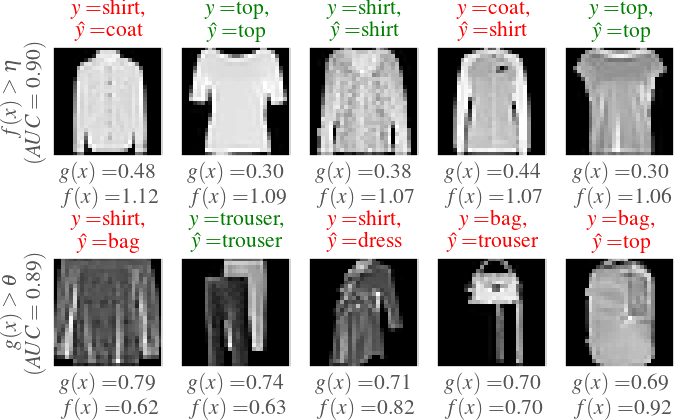

In [ ]:
# Plot selected instances
# initialize the label 
labelNames = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]
# X_test_best = X_test.reshape(-1,28,28)
# y_hat_best = y_test_pred_th[top_f_idx]
# y_th_best = np.argmax(y_test[top_f_idx], axis=1)
# Plot instances
row,col = 2,top_n
fig1, ax = plt.subplots(row, col, figsize=(6.0, 3.5), constrained_layout=True, dpi=120)
# fig1.subplots_adjust(wspace=-0.1, hspace=0.25, top=0.45)
# for i in top_f_idx:
j = 0
for i,k in zip(top_f_idx, top_crit_idx):
    if np.argmax(y_test_best, axis=1)[i] != y_test_pred_th_best[i]:
        color = 'red'
    else:
        color = 'green'
    # ax = fig1.add_subplot(3, 4, j+1)
    ax[0][j].imshow(X_test_best[i, :, :], cmap='gray', interpolation='none')
    ax[0][j].set_title(r'$y=${s1}'.format(s1=labelNames[np.argmax(y_test_best, axis=1)[i]])+',\n'+\
                    r'$\hat{{y}}=${s2}'.format(s2=labelNames[y_test_pred_th_best[i]]), color=color, fontsize=13)
    ax[0][j].set_xlabel(r"$g(x)=${:.2f}".format(crit_test[i])+'\n$f(x)=${:.2f}'.format(f_test[i]), fontsize=13)
    ax[0][j].set_xticks([])
    ax[0][j].set_yticks([])

    if np.argmax(y_test_best, axis=1)[k] != y_test_pred_th_best[k]:
        color = 'red'
    else:
        color = 'green'
    # ax = fig1.add_subplot(3, 4, j+1)
    ax[1][j].imshow(X_test_best[k, :, :], cmap='gray', interpolation='none')
    ax[1][j].set_title(r'$y=${s1}'.format(s1=labelNames[np.argmax(y_test_best, axis=1)[k]])+',\n'+\
                    r'$\hat{{y}}=${s2}'.format(s2=labelNames[y_test_pred_th_best[k]]), color=color, fontsize=13)
    ax[1][j].set_xlabel(r"$g(x)=${:.2f}".format(crit_test[k])+'\n$f(x)=${:.2f}'.format(f_test[k]), fontsize=13)
    ax[1][j].set_xticks([])
    ax[1][j].set_yticks([])
    j = j + 1
fig1.set_constrained_layout_pads(w_pad=0, h_pad=0, hspace=0.01, wspace=-.5)
ax[0][0].set_ylabel(r"$f(x)>\eta$"+"\n"+r"$(AUC={:.2f})$".format(roc_f), fontsize=13)
# ax[0][0].set_ylabel(r"$f(x)>\eta$", fontsize=14)
ax[1][0].set_ylabel(r"$g(x)>\theta$"+"\n"+r"$(AUC={:.2f})$".format(roc_crit), fontsize=13)
# ax[1][0].set_ylabel(r"$g(x)>\theta$", fontsize=14)
# fig1.text(0.5, 0.01, r'$\rho={},~|f(x)>\eta|={},~|g(x)>\theta|={}$'.format(rho,np.sum(f_test>eta),np.sum(crit_test>theta)), ha='center', fontsize = 12)
# plt.suptitle(r'Top {} selected instances'.format(top_n), fontsize=15)
# plt.tight_layout()
path_fig_fxgx_test = "drive/My Drive/NIPS2020/results/fashionMNIST/fig_fxgx_test_{clf}_yhat{yhat}_pca{pca}.svg".format(clf=clf, pca=applyPCA, yhat=addPredictions)
plt.savefig(path_fig_fxgx_test, bbox_inches='tight', facecolor='w')